In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from astropy.io import fits

In [4]:
##data from various missions

##ones that still need converting!
def magtoJy(mag,zero):
    exp = -mag/2.5
    Jy = zero*(10**exp)
    return Jy

def conv_err(merr,mag,zero):
    m = mag+merr
    j = magtoJy(m,zero)
    dF = magtoJy(mag,zero)-j
    return dF

###all in Jy
Akari_lam = 9
Akari_Jy = 0.2146 ##DQ = good
Akari_err = 0.00798

IRAS_lam = np.asarray([29,60])
IRAS_Jy = np.asarray([0.7753,0.9953]) ##DQ = 1,3,3,1 (not sure what they mean, seems like higher # is better?)
IRAS_err = 0.1*IRAS_Jy

#taken from unWISE catalog, but data quality values are garbage
#WISE_lam = np.asarray([3.35,4.6])
#WISE_Jy = np.asarray([.448,.547]) ##DQ = good good
#WISE_err = np.asarray([2.39e-04,6.21e-04])

#taken from ALLWISE, great quality all As
WISE_lam = np.asarray([3.35,4.6,11.6,22.1])
WISE_mag = np.asarray([6.975,6.895,5.684,2.804])
WISE_errm = np.asarray([0.053,0.020,0.015,0.018])
WISE_Jy = np.asarray([magtoJy(WISE_mag[0],309.54),magtoJy(WISE_mag[1],171.787),magtoJy(WISE_mag[2],31.674),magtoJy(WISE_mag[3],8.363)])
WISE_err = np.asarray([conv_err(WISE_errm[0],WISE_mag[0],309.54),conv_err(WISE_errm[1],WISE_mag[1],171.787),conv_err(WISE_errm[2],WISE_mag[2],31.674),conv_err(WISE_errm[3],WISE_mag[3],8.363)])
print('WISE')
print(WISE_Jy)
print(WISE_err)

##2MASS data
MASS_lam = np.asarray([1.25,1.65,2.17])
MASS_mag = np.asarray([7.089,7.109,7.01]) ##DQ = good, good, good
MASS_err = np.asarray([0.024,0.024,0.024])
MASS_errj = np.asarray([conv_err(MASS_err[0],MASS_mag[0],1577),conv_err(MASS_err[1],MASS_mag[1],1050),conv_err(MASS_err[2],MASS_mag[2],674.9)])
MASS_Jy = np.asarray([magtoJy(MASS_mag[0],1577),magtoJy(MASS_mag[1],1050),magtoJy(MASS_mag[2],674.9)])
print('2MASS')
print(MASS_Jy)
print(MASS_errj)

##visible data (Tycho and Gaia)
vis_lam = np.asarray([0.442,0.54])
vis_mag = np.asarray([7.374,7.271]) ##DQ = good good
vis_errm = np.asarray([np.nan,np.nan])
vis_Jy = np.asarray([magtoJy(vis_mag[0],4063),magtoJy(vis_mag[1],3636)]) #previous zero points without sources 3985,3746
vis_err = 0.1*vis_Jy
print('Tycho')
print(vis_Jy)
print(vis_err)

##ALMA
ALMA_lam = 1240
ALMA_Jy = 720e-6 ##DQ = not given
ALMA_err = 110e-6

WISE
[0.5020151  0.29990955 0.16869527 0.63206552]
[0.02391726 0.00547397 0.00231459 0.01039239]
2MASS
[2.30266995 1.50518298 1.05983786]
[0.05034165 0.03290676 0.02317049]
Tycho
[4.56296169 4.48976773]
[0.45629617 0.44897677]


In [5]:
##all good photometry and corresponding wavelengths in one array for fits
phot = np.asarray([0.2146,0.7753,0.9953,0.5020151,0.29990955,0.16869527,0.63206552,2.30266995,1.50518298,1.05983786,4.56296169,4.48976773,720e-6])
lam = np.asarray([9,29,60,3.35,4.6,11.6,22.1,1.25,1.65,2.17,0.442,0.54,1240])
sigma = np.asarray([0.00798,0.077,0.099,0.02391726,0.00547397,0.00231459,0.01039239,0.05034165,0.03290676,0.02317049,0.45,0.44,110e-6])

In [6]:
assert len(phot) == len(lam) == len(sigma)

In [7]:
###distance to HD 156623
p=8.9484 #from Simbad
d=1/(p*1e-3) #given in mas, distance in pc
print(d)

111.75182155469133


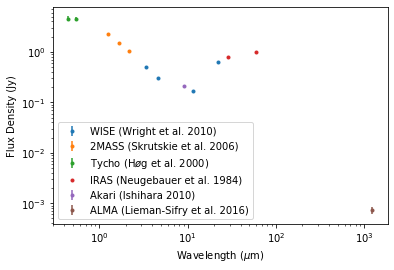

In [8]:
plt.errorbar(WISE_lam,WISE_Jy,yerr=WISE_err,fmt=".",label='WISE (Wright et al. 2010)')
plt.errorbar(MASS_lam,MASS_Jy,yerr=MASS_errj,fmt=".",label='2MASS (Skrutskie et al. 2006)')
plt.errorbar(vis_lam,vis_Jy,yerr=vis_err,fmt=".",label='Tycho (H$\o$g et al. 2000)')
plt.errorbar(IRAS_lam,IRAS_Jy,fmt=".",label='IRAS (Neugebauer et al. 1984)')
plt.errorbar(Akari_lam,Akari_Jy,yerr=Akari_err,fmt=".",label='Akari (Ishihara 2010)')
plt.errorbar(ALMA_lam,ALMA_Jy,yerr=ALMA_err,fmt=".",label='ALMA (Lieman-Sifry et al. 2016)')
plt.legend(loc=3)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux Density (Jy)')
plt.savefig('../plots/HD156623-photometry.png',dpi=500)

In [10]:
##let's try making our own blackbody
import sys
sys.path.append('../')
from cgs import *
def Bv_lam(T,lam):
    '''Bv in terms of wavelength—all in cgs units'''
    exp = np.exp((h*c)/(lam*k*T))
    Bv = (2*h*c)/(lam**3) * (1/(exp-1))
    return Bv

wavelengths = np.linspace(5e-6,0.5,10000000) #wavelengths are in cm, multiply by 1e4 to get microns

#and we need to convert to Jy
def toJy_star(Bv,Rstar):
    """planck fn erg/s/cm2/sr/hz to jy (1e23 erg/s/cm2/hz),scaled by distance to hd15623 (111pc), Rstar for A0V ~2Rsun. 
    Rstar in solar radii, T in Kelvin, Bv in erg/s/cm2/sr/Hz"""
    cm = Rstar*7e10 #cm
    sr = (cm**2) #cm2
    steradians = np.pi #sr converts from brightness to flux
    Bv = Bv*sr*steradians #erg/s/cm2/sr/hz times cm2 and sr = erg/s/hz
    d = 112*(3e18) #pc to cm
    Bv = Bv/(d**2) #erg/s/sr/hz divided by cm2 = erg/s/cm2/sr/hz
    Jy = Bv*1e23 #1 erg/s/cm2/hz = 1e23 Jy
    return Jy

def toJy_disk(Bv,A):
    """planck fn erg/s/cm2/sr/hz to jy (1e23 erg/s/cm2/hz),scaled by distance to hd15623 (111pc), Rstar for A0V ~2Rsun. 
    Rstar in solar radii, T in Kelvin, Bv in erg/s/cm2/sr/Hz"""
    steradians = np.pi #sr
    Bv = Bv*A*steradians #erg/s/cm2/sr/hz times cm2 and sr = erg/s/hz
    d = 112*(3e18) #pc to cm
    Bv = Bv/(d**2) #erg/s/sr/hz divided by cm2 = erg/s/cm2/sr/hz
    Jy = Bv*1e23 #1 erg/s/cm2/hz = 1e23 Jy
    return Jy